In [1]:
import glob
import pandas as pd
import tqdm
from pyfasta import Fasta
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [45]:
import seaborn as sns
import numpy as np

## Filter Names and get rid of plasmids if possible

In [17]:
taxamap = "/mnt/scratch3/hirak/meta_genome/bacteria_all/seqid2taxid.map"
seqtaxamap = pd.read_table(taxamap,names=['organism','txid'])
name_dict = {}
with open("/mnt/scratch3/hirak/meta_genome/reference/names.list") as fp:
    names = fp.readlines()
    for line in names:
        name_dict["|".join(line.strip().split("|")[:4]) + "|"] = line.strip().split("|")[4].split(",")[0].strip()
seqtaxamap.loc[:,'names'] = seqtaxamap.organism.map(name_dict.get)
txid_name_tuples = zip(seqtaxamap.names.values,seqtaxamap.txid)

In [24]:
duplicated_txid = defaultdict(list)
for name,txid in txid_name_tuples:
    duplicated_txid[txid].append(name)

In [38]:
plasmid_removed = {}
for tid, names in duplicated_txid.items():
    if len(names) > 1:
        for name in names:
            if not 'plasmid' in name:
                plasmid_removed[tid] = name
        if not tid in plasmid_removed:
            plasmid_removed[tid] = names[-1]
    else:
        plasmid_removed[tid] = names[0] 

## Read cedar files (files that has count values for each species) to summerize the data

In [64]:
def readCedarfiles(cedarfiles):
    cedar_df = pd.DataFrame(index=plasmid_removed.keys())
    for ced1 in tqdm.tqdm(cedarfiles):
        samplename = ced1.split("/")[-1].split(".")[0]
        df_ced1 = pd.read_table(ced1,usecols=['taxaId','count'])
        df_ced1.columns = ['taxaId',samplename]
        df_ced1.set_index(['taxaId'],inplace=True)
        cedar_df = cedar_df.join(df_ced1)
    cedar_df = cedar_df.fillna(0.0)
    cedar_df['names']=cedar_df.index.map(plasmid_removed.get)
    cedar_df.set_index(['names'],inplace=True)
    return cedar_df

In [65]:
def thresholdDataframe(cedar_df,threshold):
    return cedar_df[cedar_df.sum(axis=1) > threshold]

In [66]:
cedarfiles = glob.glob("/mnt/scratch3/hirak/meta_genome/cedarfiles/*.cedar")
cedar_df = readCedarfiles(cedarfiles)

100%|██████████| 99/99 [00:00<00:00, 148.04it/s]


### Heatmap of Non-zero elements

In [71]:
cedar_df_non_zero = thresholdDataframe(cedar_df,0.0)
print("Number of organism which is expressed in any of the samples: {}".format(len(cedar_df_non_zero)))

Number of organism which is expressed in any of the samples: 224


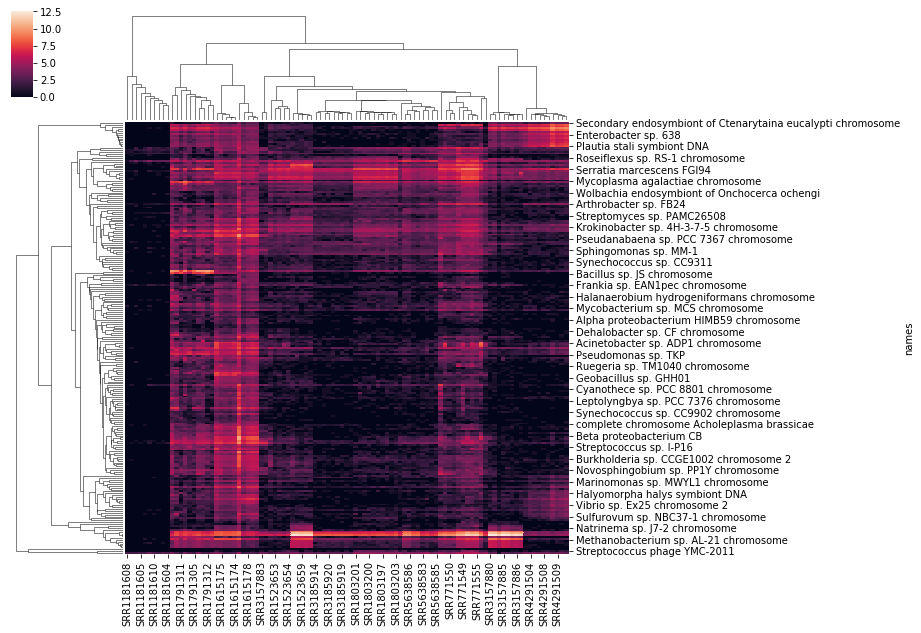

In [72]:
sns.clustermap(np.log(cedar_df_non_zero+1),metric='correlation')

### Heatmap of organisms with more than a threshold

In [74]:
cedar_df_100 = thresholdDataframe(cedar_df,100.0)
print("Number of organism which is expressed with more than 100 counts in any of the samples: {}".format(len(cedar_df_100)))

Number of organism which is expressed with more than 100 counts in any of the samples: 223


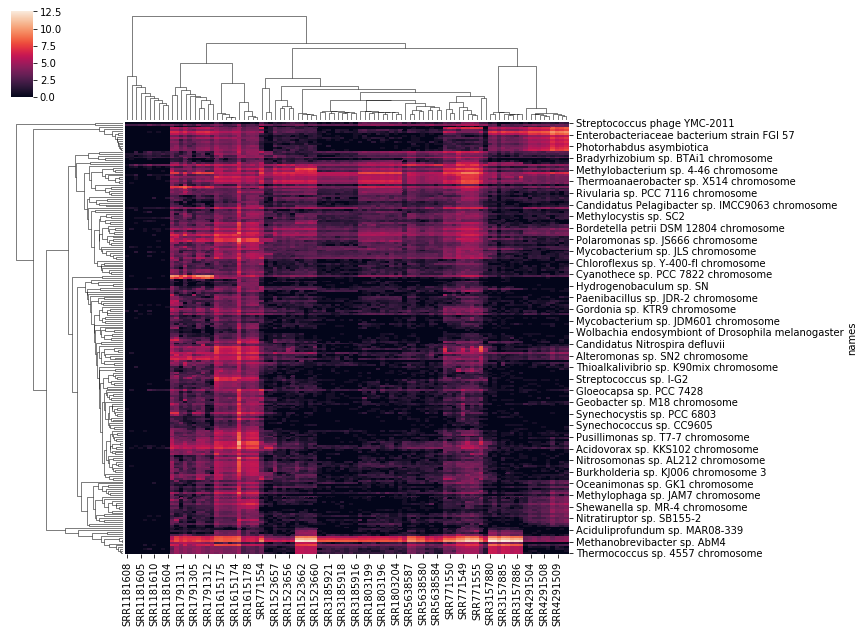

In [75]:
sns.clustermap(np.log(cedar_df_100+1),metric='correlation')

In [76]:
cedar_df_1000 = thresholdDataframe(cedar_df,1000.0)
print("Number of organism which is expressed with more than 1000 counts in any of the samples: {}".format(len(cedar_df_1000)))

Number of organism which is expressed with more than 1000 counts in any of the samples: 180


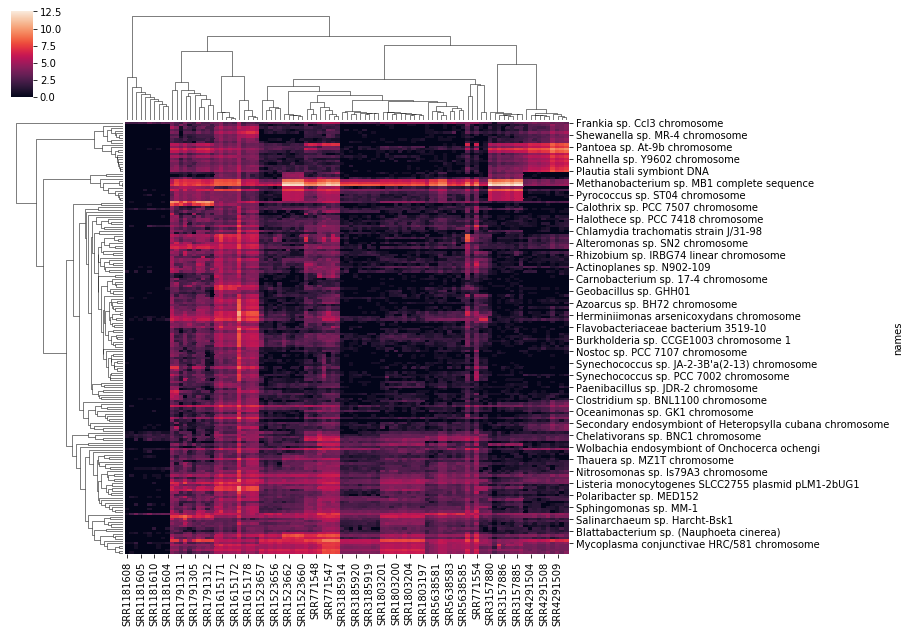

In [77]:
sns.clustermap(np.log(cedar_df_1000+1),metric='correlation')

In [78]:
cedar_df_10000 = thresholdDataframe(cedar_df,10000.0)
print("Number of organism which is expressed with more than 1000 counts in any of the samples: {}".format(len(cedar_df_10000)))

Number of organism which is expressed with more than 1000 counts in any of the samples: 40


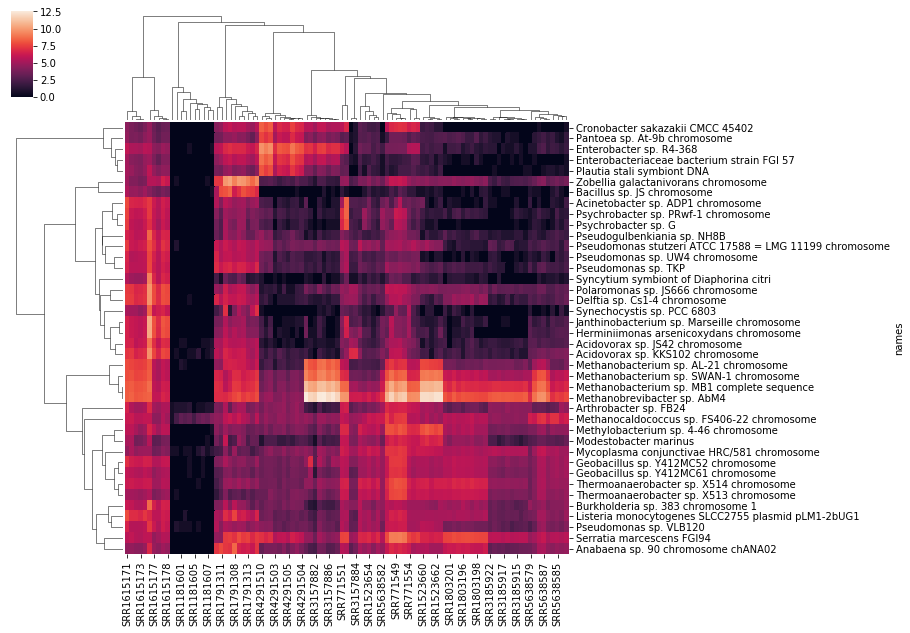

In [79]:
sns.clustermap(np.log(cedar_df_10000+1),metric='correlation')

## Read `--perfect` cedar files (files that has count values for each species) to summerize the data

### Explanation: The perfect flag only keeps species that are *fully* covered by the sample. 

In [81]:
perfect_cedar = glob.glob("/mnt/scratch3/hirak/meta_genome/cedarfiles_perfect/*.cedar")
cedar_pf_df = readCedarfiles(perfect_cedar)

100%|██████████| 94/94 [00:02<00:00, 33.70it/s]


### Heatmap of Non-zero elements

In [83]:
cedar_pf_df_non_zero = thresholdDataframe(cedar_pf_df,0.0)

In [94]:
print("Number of organism which is expressed in any of the samples: {}".format(len(cedar_pf_df_non_zero)))

Number of organism which is expressed in any of the samples: 219


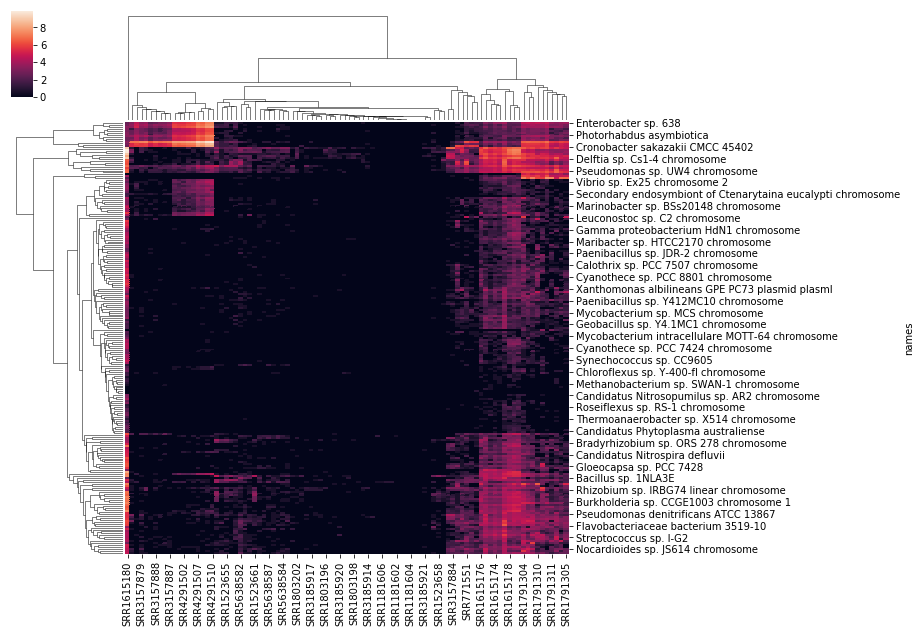

In [97]:
sns.clustermap(np.log(cedar_pf_df_non_zero+1))

In [98]:
cedar_pf_df_100 = thresholdDataframe(cedar_pf_df,100.0)
print("Number of organism which is expressed with more than 100 counts in any of the samples: {}".format(len(cedar_pf_df_100)))

Number of organism which is expressed with more than 100 counts in any of the samples: 170


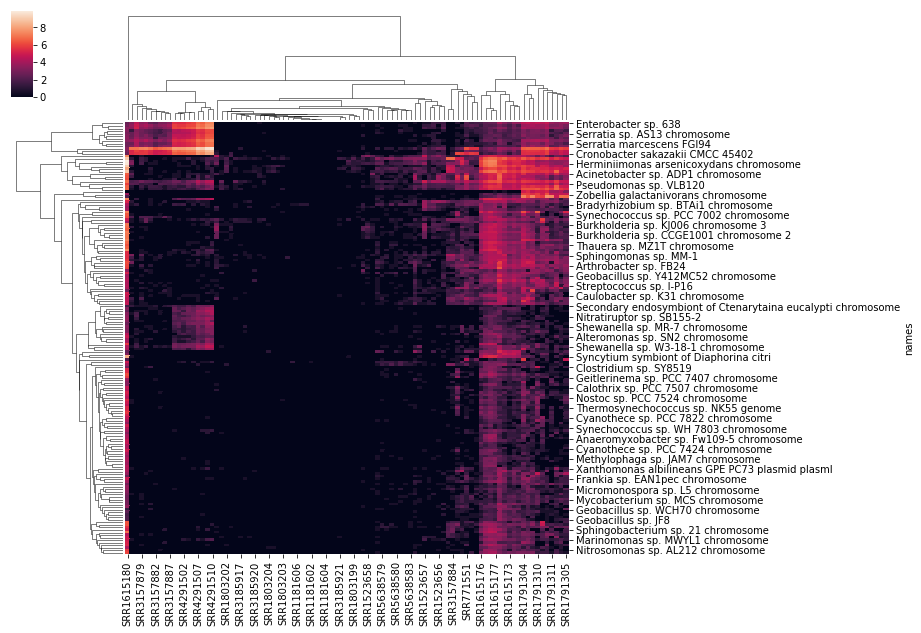

In [99]:
sns.clustermap(np.log(cedar_pf_df_100+1))

In [105]:
cedar_pf_df_1000 = thresholdDataframe(cedar_pf_df,1000.0)
print("Number of organism which is expressed with more than 1000 counts in any of the samples: {}".format(len(cedar_pf_df_1000)))

Number of organism which is expressed with more than 1000 counts in any of the samples: 59


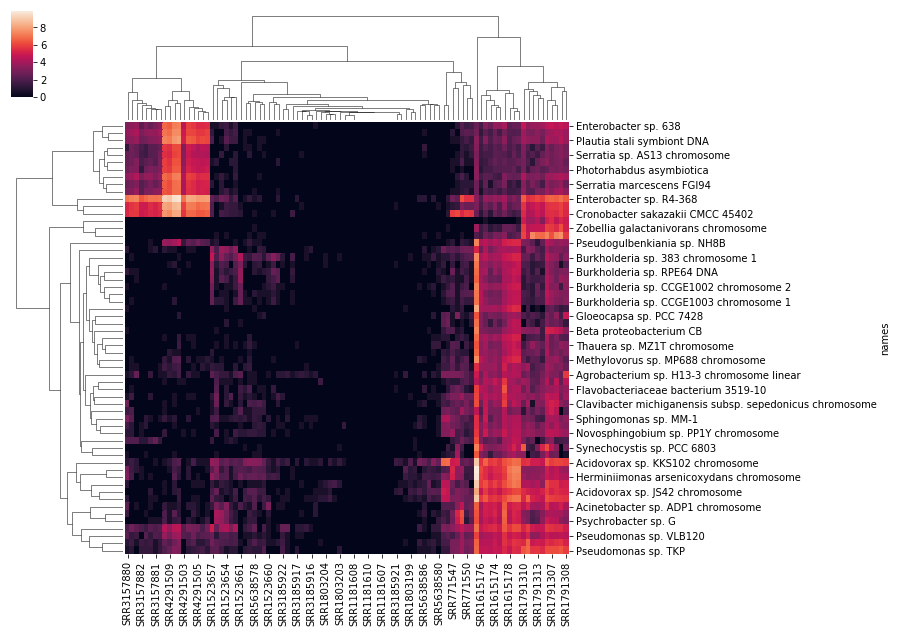

In [103]:
sns.clustermap(np.log(cedar_pf_df_1000+1))

In [104]:
cedar_pf_df_10000 = thresholdDataframe(cedar_pf_df,10000.0)
print("Number of organism which is expressed with more than 10000 counts in any of the samples: {}".format(len(cedar_pf_df_10000)))

Number of organism which is expressed with more than 10000 counts in any of the samples: 10


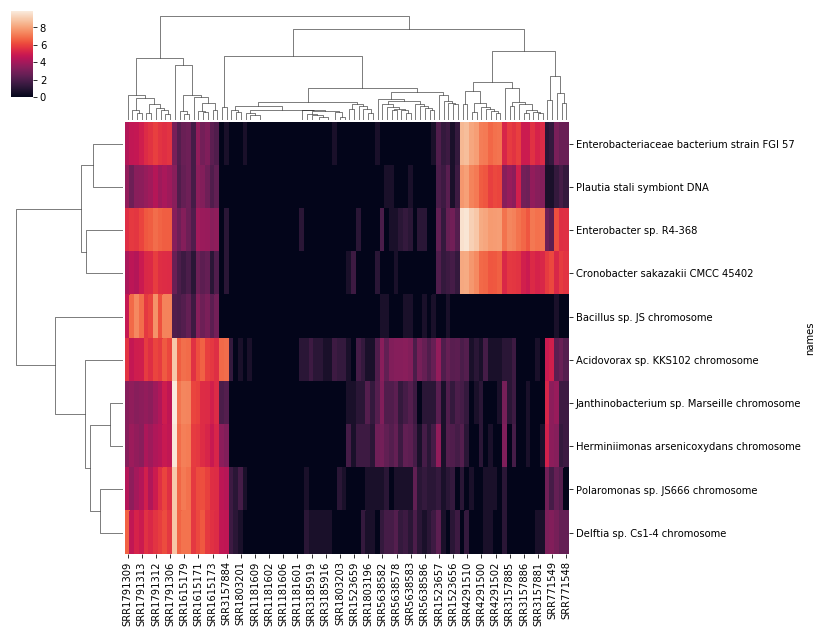

In [101]:
sns.clustermap(np.log(cedar_pf_df_10000+1))